In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk', font_scale=1.5)
sns.set(color_codes=True)

%matplotlib inline

In [2]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    from ysi_utils.models import outlier_model, bagging_model, ensemble_predict
    ensemble_predict.bagging_model = bagging_model()

Using Theano backend.


In [3]:
from ysi_utils.descriptors import dragon_ron
from ysi_utils.data import ron, low, addl_mols
from ysi_utils.tools.descriptors import get_element_dict, get_DBE
from ysi_utils.tools import chemical_conversions

#ron.SMILES = ron.SMILES.apply(chemical_conversions.canonicalize_smiles)

valid_ron = ron[~ron.RON.str.contains('>')].copy()
valid_ron.RON = valid_ron.RON.astype('float')

In [4]:
ron_df = valid_ron.set_index('SMILES')
ron_df['inlier'] = outlier_model.predict(dragon_ron.loc[ron_df.index]) == 1

In [5]:
predictions = pd.DataFrame(ensemble_predict(dragon_ron.loc[ron_df.index]), index=ron_df.index)
ron_df['YSI'] = predictions.mean(1)
ron_df['YSI_std'] = predictions.std(1)
ron_df.head()

,IUPAC name,CAS,RON,source RON,inlier,YSI,YSI_std
SMILES,,,,,,,
C=CCCCC,1-Hexene,592-41-6,76.0,API Report,True,15.235844,1.730438
CC(C)=CC(C)C,"2,4-dimethyl-2-pentene",625-65-0,100.0,API Report,True,58.909860,5.397653
Cc1ccc(C)o1,"2,5-Dimethylfuran",625-86-5,101.3,API Report,False,73.031421,11.812839
CC(C)CCCC(C)C,"2,6- Dimethylheptane",1072-05-5,36.0,"Ind. Eng. Chem., 1941, 33 (4), pp 554-560",True,49.168216,3.759263
CCC(C)O,2-butanol,78-92-2,107.0,"Christensen, 2011",True,-7.394225,1.031740


In [6]:
low_join = low.append(addl_mols.rename(columns={'Name': 'Species'}))

In [7]:
measured_ysi = low_join.loc[low_join.SMILES.isin(ron_df.index)].set_index('SMILES')['YSI']
ron_df['measured_ysi'] = ron_df.index.isin(measured_ysi.index)
ron_df.loc[measured_ysi.index, 'YSI'] = measured_ysi
ron_df.loc[measured_ysi.index, 'YSI_std'] = 0.58

Drop points that neither have a measured YSI value nor pass the applicability domain test

In [9]:
ron_df = ron_df[~((~ron_df.inlier) & (~ron_df.measured_ysi))]

In [28]:
'Measured values for {0} of {1} fuels'.format(sum(ron_df.measured_ysi), len(ron_df))

'Measured values for 58 of 69 fuels'

In [11]:
from ysi_utils.tools.descriptors import get_element_dict
is_oxygenate = ron_df.reset_index().SMILES.apply(get_element_dict).fillna(0)['O'] > 0
is_oxygenate.index = ron_df.index

ron_df['type'] = 'hydrocarbon'
ron_df.loc[is_oxygenate, 'type'] = 'oxygenate'

In [19]:
ron_df['color'] = pd.Series(['b', 'r']).loc[is_oxygenate.astype(int)].values

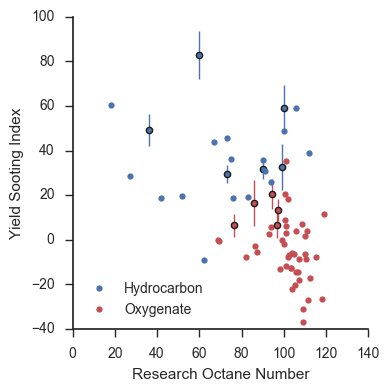

In [29]:
from matplotlib.lines import Line2D

with sns.axes_style('ticks'):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    
    for index, row in ron_df.iterrows():
        
           
        #ax.errorbar(ron, ysi, yerr=1.96*err, marker=m, c=c, markersize=ms,
        #            markeredgewidth=lw, elinewidth=1, capsize=0)
        
        if row.measured_ysi:
            ax.plot(row.RON, row.YSI, marker='o', c=row.color, markersize=4.5, markeredgewidth=0)
        else:
            ax.errorbar(row.RON, row.YSI, yerr=1.96*row.YSI_std, marker='o', c=row.color, markersize=4.5,
                        markeredgewidth=1, elinewidth=1, capsize=0)
    
    hydrocarbon = Line2D([1],[1], color='b', marker='o', markerfacecolor='b', lw=0, markersize=4.5)
    oxygenate = Line2D([1],[1], color='b', marker='o', markerfacecolor='r', lw=0, markersize=4.5)
    #aromatic = Line2D([1],[1], color='b', marker='x', markerfacecolor='r', lw=0, markersize=5, markeredgewidth=2)
    #oaromatic = Line2D([1],[1], color='r', marker='x', markerfacecolor='r', lw=0, markersize=5, markeredgewidth=2)


    
    ax.set_xlim([0, 140])
    ax.set_ylim([-40, 100])

    
    ax.legend((hydrocarbon, oxygenate),
              ('Hydrocarbon', 'Oxygenate'), loc='lower left', ncol=1)
    sns.despine()
    
    ax.set_xlabel('Research Octane Number')
    ax.set_ylabel('Yield Sooting Index')
    
    fig.tight_layout()
    fig.savefig('ysi_vs_ron.svg', transparent=True)

In [22]:
row

IUPAC name      2,4-dimethyl-2-pentene
CAS                           625-65-0
RON                                100
source RON                  API Report
inlier                            True
YSI                            58.9099
YSI_std                        5.39765
measured_ysi                     False
type                       hydrocarbon
color                                b
Name: CC(C)=CC(C)C, dtype: object

In [22]:
print(ron_df[(ron_df.YSI < -20) & (ron_df.RON > 100)].loc[:, ['IUPAC name', 'RON', 'YSI']].set_index('IUPAC name'))

                           RON   YSI
IUPAC name                          
2-Butanone               105.3 -20.5
n-Propanol               104.0 -22.0
Acetic acid ethyl ester  118.0 -26.4
Ethanol                  109.0 -31.1
2-Propanone              111.3 -26.9
Methanol                 109.0 -36.9


In [25]:
output_df = ron_df.copy()
output_df['YSI source'] = 'Model Prediction'
output_df.loc[measured_ysi.index, 'YSI source'] = 'McEnally & Pfefferle, 2011'
output_df['RON source'] = output_df['source RON']
output_df = output_df.drop(['type', 'source RON'], 1)
output_df.reset_index(drop=True).to_csv('ron_ysi_predictions.csv', index=False, float_format='%.3f')

In [27]:
ron_df[ron_df.type == 'oxygenate'].sort_values('YSI').head()

,IUPAC name,CAS,RON,source RON,inlier,YSI,YSI_std,measured_ysi,type
SMILES,,,,,,,,,
CO,Methanol,67-56-1,109.0,"Anderson, et al., 2010",False,-36.9,0.58,True,oxygenate
CCO,Ethanol,64-17-5,109.0,"Hunwartzen, I SAE Paper 82002, 1982. DOI: 10.4...",False,-31.1,0.58,True,oxygenate
CC(C)=O,2-Propanone,67-64-1,111.3,NaN,False,-26.9,0.58,True,oxygenate
CCOC(C)=O,Acetic acid ethyl ester,141-78-6,118.0,"NREL, March 2016 JCE-4-42309-01, WO #56",True,-26.4,0.58,True,oxygenate
CCCO,n-Propanol,71-23-8,104.0,"Christensen, 2011",True,-22.0,0.58,True,oxygenate
